# Tutorial for occ_find

occ_find is a stellar occultation detection software for finding occultation events from 1.54m Danish telescope TCI spool files. The spool files come in the HDF5 format, and require unpacking before processing.

## Imports

In [7]:
import tables as tb
from tqdm import trange, tqdm_notebook
from time import sleep
############################################################  occ_find imports  #############################################################
from occ_find import occ_find
from h5_unpack import h5_unpack
from reducto import reducto
from plot_lc import plot_lc

## Example without image reduction

Start by specifying the spool file and it's parent directory as strings; in this example, we have used a spool file called 'Ixion_Llr_2023-07-28_00100.h5'. h5_unpack will create a directory with the name of the spool file and a subdirectory within that called 'images'. It will then place each image into the images directory as a fits file, and will save the metadata to txt files in the main spool directory. h5_unpack is called as follows:

If this is your first time using the code, be sure to run h5_unpack and occ_find in separate blocks to ensure the HDF5 file has been successfully unpacked before proceeding to run occ_find. Once h5_unpack has sucessfully run and unpacked the HDF5 file, occ_find can be called.

When called, occ_find will create a directory named 'photData', then pick the first image out of the 'images' directory and use a source finding routine - photutils IRAFStarFinder - to locate any sources. IRAFStarFinder will locate any sources with fluxes above a threshold, corresponding to a percentage above the median pixel value specified by 'thresh-factor'. Apertures with diameter 'fwhm', and annuli with diameters 2x and 3x 'fwhm' will be placed on each detected source. occ_find will then return a plot of the detected sources. Having detected sources and placed apertures, occ_find performs aperture photometry on each source, recording the photometry results for each source in their own log. Upon completion of the photometry, occ_find will plot the lightcurves of the detected sources which can be inspected for occultation events.

Some important notes on running occ_find for the first time:

1. Set make_dir to 'True' when first running occ_find on **any** spool file. Otherwise, the directory for the photometry and source data will not be created.
2. For the 'fwhm' and 'thresh_factor' values, a default initial value of 16 and 0.2 are reccommended respectively. If no sources are detected initially, or sources are not being locked onto (due to them being too faint, or poor observation conditions), try increasing 'fwhm', decreasing 'thresh_factor', or both. Also be sure to check the snapshot immediately after running to see if the images are even useable.

In [8]:
spool_file = 'Ixion_Llr_2023-07-28_00100.h5'
file_dir = str('/home/benattwood/Documents/occ_find/')

In [9]:
h5_unpack(spool_file, file_dir)

FileExistsError: [Errno 17] File exists: '/home/benattwood/Documents/occ_find/Ixion_Llr_2023-07-28_00100'

Directory 'photData' created successfully.
Filename: /home/benattwood/Documents/occ_find/Ixion_Llr_2023-07-28_00100/images/Ixion_Llr_2023-07-28_00100_imageData_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (538, 512)   int16 (rescales to uint16)   
108.76424183898699 107.0 7.34270380046514
 id xcentroid ycentroid  fwhm sharpness roundness   pa   npix  sky   peak    flux    mag  
--- --------- --------- ----- --------- --------- ------ ---- ----- ------ -------- ------
  1    185.45     58.53 13.50      0.63      0.21  54.88  270 -0.71 142.94  4057.12  -9.02
  2    237.28    166.13 12.15      0.57      0.03   8.39  402  1.68 147.56 11806.65 -10.18
  3    418.26    244.43 12.09      0.56      0.10 111.31  339  0.29  78.95  5715.55  -9.39
  4    226.43    370.78 12.99      0.61      0.08  25.58  282  3.37  69.87  4032.68  -9.01
  5    411.15    408.71 11.97      0.56      0.07 125.93  337  3.10 101.13  5177.60  -9.29


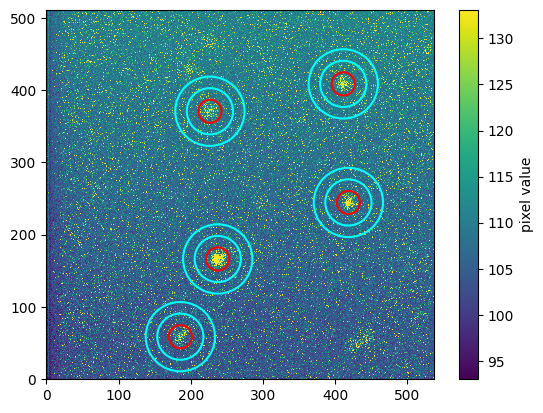

100%|█████████████████████████████████████████████████████████████████████| 3000/3000 [01:13<00:00, 40.86it/s]


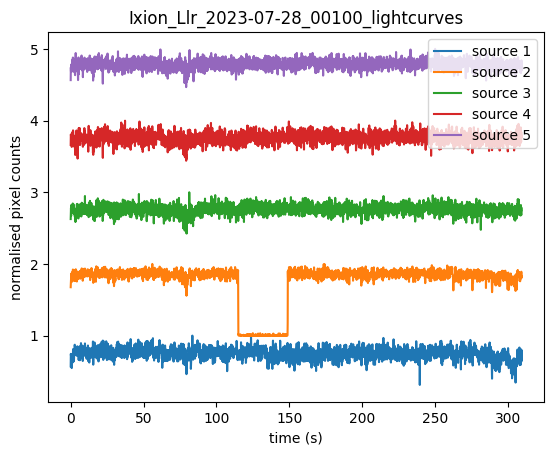

In [10]:
occ_find(file_dir, spool_file, make_dir=True, reduced=False, fwhm=16, thresh_factor=0.2)

## Example with image reduction

If image reduction is to be included, then we simply introduce an additional step where the reduction script 'reducto' is called. This reduces the images by flat fielding them (bias subtraction was initially included, but would always cause negative pixels in the testing, it has been discarded for now). 
Before proceeding, note that **reducto must be called for each image**. To reduce a set of images, specify the 'images' directory path, along with the first observation image, and the flat field image - all as strings. Run reducto for the first image in the 'images' directory, then create the loop shown in the 3rd block of code below. Following reduction, occ_find can be called as it was in the example above, setting the 'reduced' variable to 'True'.

From start to finish, with image reduction, the process goes as follows:

In [2]:
spool_file = 'Ixion_Llr_2023-07-28_00100.h5'
file_dir = str('/home/benattwood/Documents/occ_find/')

In [ ]:
h5_unpack(spool_file, file_dir)

In [10]:
im_dir = file_dir + str('Ixion_Llr_2023-07-28_00100/images/')
start_im = str('Ixion_Llr_2023-07-28_00100_imageData_0.fits')
flat_im = str('Ixion_Llr_2023-07-28_00100_flat.fits')

reducto(start_im, flat_im, im_dir, make_dir = True)
t = tb.open_file(spool_file)
for i in trange(len(t.root.imageData)):
    image_file = str('Ixion_Llr_2023-07-28_00100_imageData_')+str(i)+str('.fits')
    reducto(image_file, flat_im, im_dir, make_dir = False)
    sleep(0.01) 

Directory 'reduced' created successfully.


100%|█████████████████████████████████████████████████████████████████████| 3000/3000 [12:20<00:00,  4.05it/s]


Directory 'photData' created successfully.
Filename: /home/benattwood/Documents/occ_find/Ixion_Llr_2023-07-28_00100/reduced/Ixion_Llr_2023-07-28_00100_imageData_0_reduced.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   (505, 512)   float64   
104.12718087443655 102.60676412926591 8.25221095210131
 id xcentroid ycentroid  fwhm sharpness roundness   pa   npix  sky   peak    flux    mag  
--- --------- --------- ----- --------- --------- ------ ---- ----- ------ -------- ------
  1    160.44     58.56 13.00      0.63      0.21  56.01  272 -3.14 133.71  3659.37  -8.91
  2    211.91    165.90 11.61      0.57      0.04   1.80  366  0.57 136.91 10237.62 -10.03
  3    393.08    244.37 11.90      0.58      0.11 106.95  337 -2.16  73.29  5247.83  -9.30
  4    200.81    370.39 12.68      0.62      0.04  40.11  296  4.57  69.07  3972.08  -9.00
  5    386.08    409.01 11.89      0.58      0.08 117.98  318  3.70  97.64  5050.31  -9.26


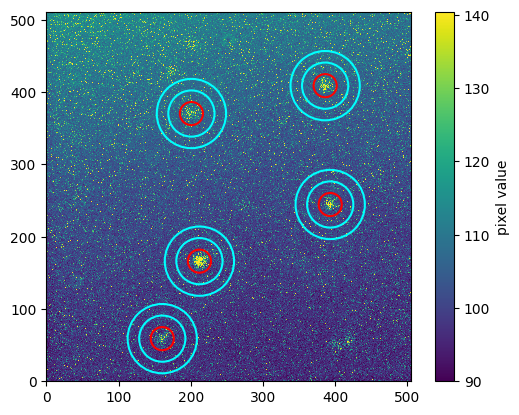

100%|█████████████████████████████████████████████████████████████████████| 3000/3000 [01:49<00:00, 27.35it/s]


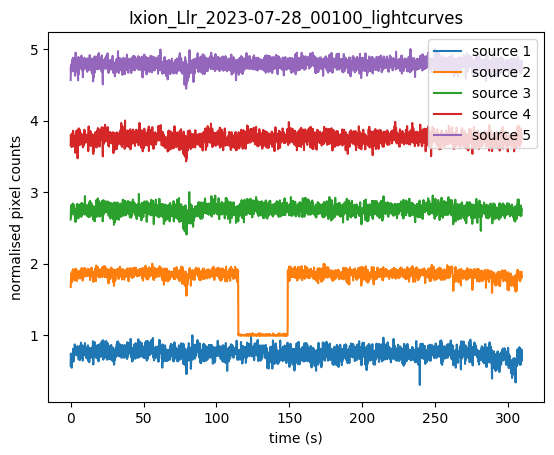

In [5]:
occ_find(file_dir, spool_file, make_dir=True, reduced=True, fwhm=16, thresh_factor=0.2)